# AIPI 590 - XAI | Assignment #6
### Explainable Techniques II: Producing PDP, ICE, and ALE plots
### Ritu Toshniwal

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ritu1412/Interpretability_Plots/blob/main/notebooks/interpretable_plots.ipynb)

In [ ]:
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "Interpretability_Plots"
git_path = 'https://github.com/ritu1412/Interpretability_Plots.git' #Change to your path
!git clone "{git_path}"

# Install requirements
!pip install -r "{os.path.join(repo_name,'requirements.txt')}"

# Change working directory to location of notebook
notebook_dir = 'notebooks'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

In [20]:
#data imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
import seaborn as sns
# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# XAI imports
import shap
from alepython import ale_plot
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore")

UCI Dataset Link: https://archive.ics.uci.edu/dataset/327/phishing+websites

In [4]:
# fetch UCI Phishing dataset 
phishing_websites = fetch_ucirepo(id=327)

In [9]:
# data (as pandas dataframes) 
X = phishing_websites.data.features 
y = phishing_websites.data.targets 

# Performing EDA

In [13]:
# feature information 
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   having_ip_address           11055 non-null  int64
 1   url_length                  11055 non-null  int64
 2   shortining_service          11055 non-null  int64
 3   having_at_symbol            11055 non-null  int64
 4   double_slash_redirecting    11055 non-null  int64
 5   prefix_suffix               11055 non-null  int64
 6   having_sub_domain           11055 non-null  int64
 7   sslfinal_state              11055 non-null  int64
 8   domain_registration_length  11055 non-null  int64
 9   favicon                     11055 non-null  int64
 10  port                        11055 non-null  int64
 11  https_token                 11055 non-null  int64
 12  request_url                 11055 non-null  int64
 13  url_of_anchor               11055 non-null  int64
 14  links_

In [14]:
#target information
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   result  11055 non-null  int64
dtypes: int64(1)
memory usage: 86.5 KB


In [17]:
print(X.isnull().sum())

having_ip_address             0
url_length                    0
shortining_service            0
having_at_symbol              0
double_slash_redirecting      0
prefix_suffix                 0
having_sub_domain             0
sslfinal_state                0
domain_registration_length    0
favicon                       0
port                          0
https_token                   0
request_url                   0
url_of_anchor                 0
links_in_tags                 0
sfh                           0
submitting_to_email           0
abnormal_url                  0
redirect                      0
on_mouseover                  0
rightclick                    0
popupwindow                   0
iframe                        0
age_of_domain                 0
dnsrecord                     0
web_traffic                   0
page_rank                     0
google_index                  0
links_pointing_to_page        0
statistical_report            0
dtype: int64


In [18]:
print(y.isnull().sum())

result    0
dtype: int64


No Null values in the dataset

In [19]:
y.value_counts()

result
 1        6157
-1        4898
Name: count, dtype: int64

### Visualizing the class distribution

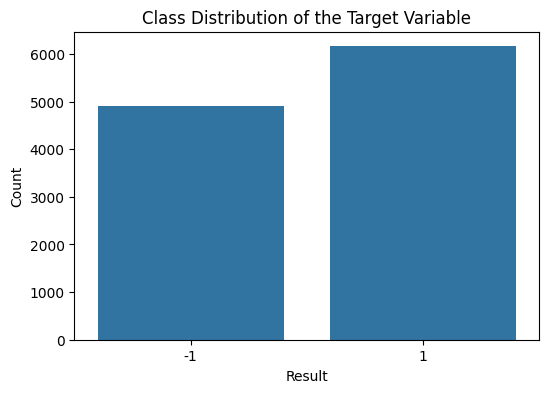

In [21]:
plt.figure(figsize=(6,4))
sns.countplot(x='result', data=y)
plt.title('Class Distribution of the Target Variable')
plt.xlabel('Result')
plt.ylabel('Count')
plt.show()

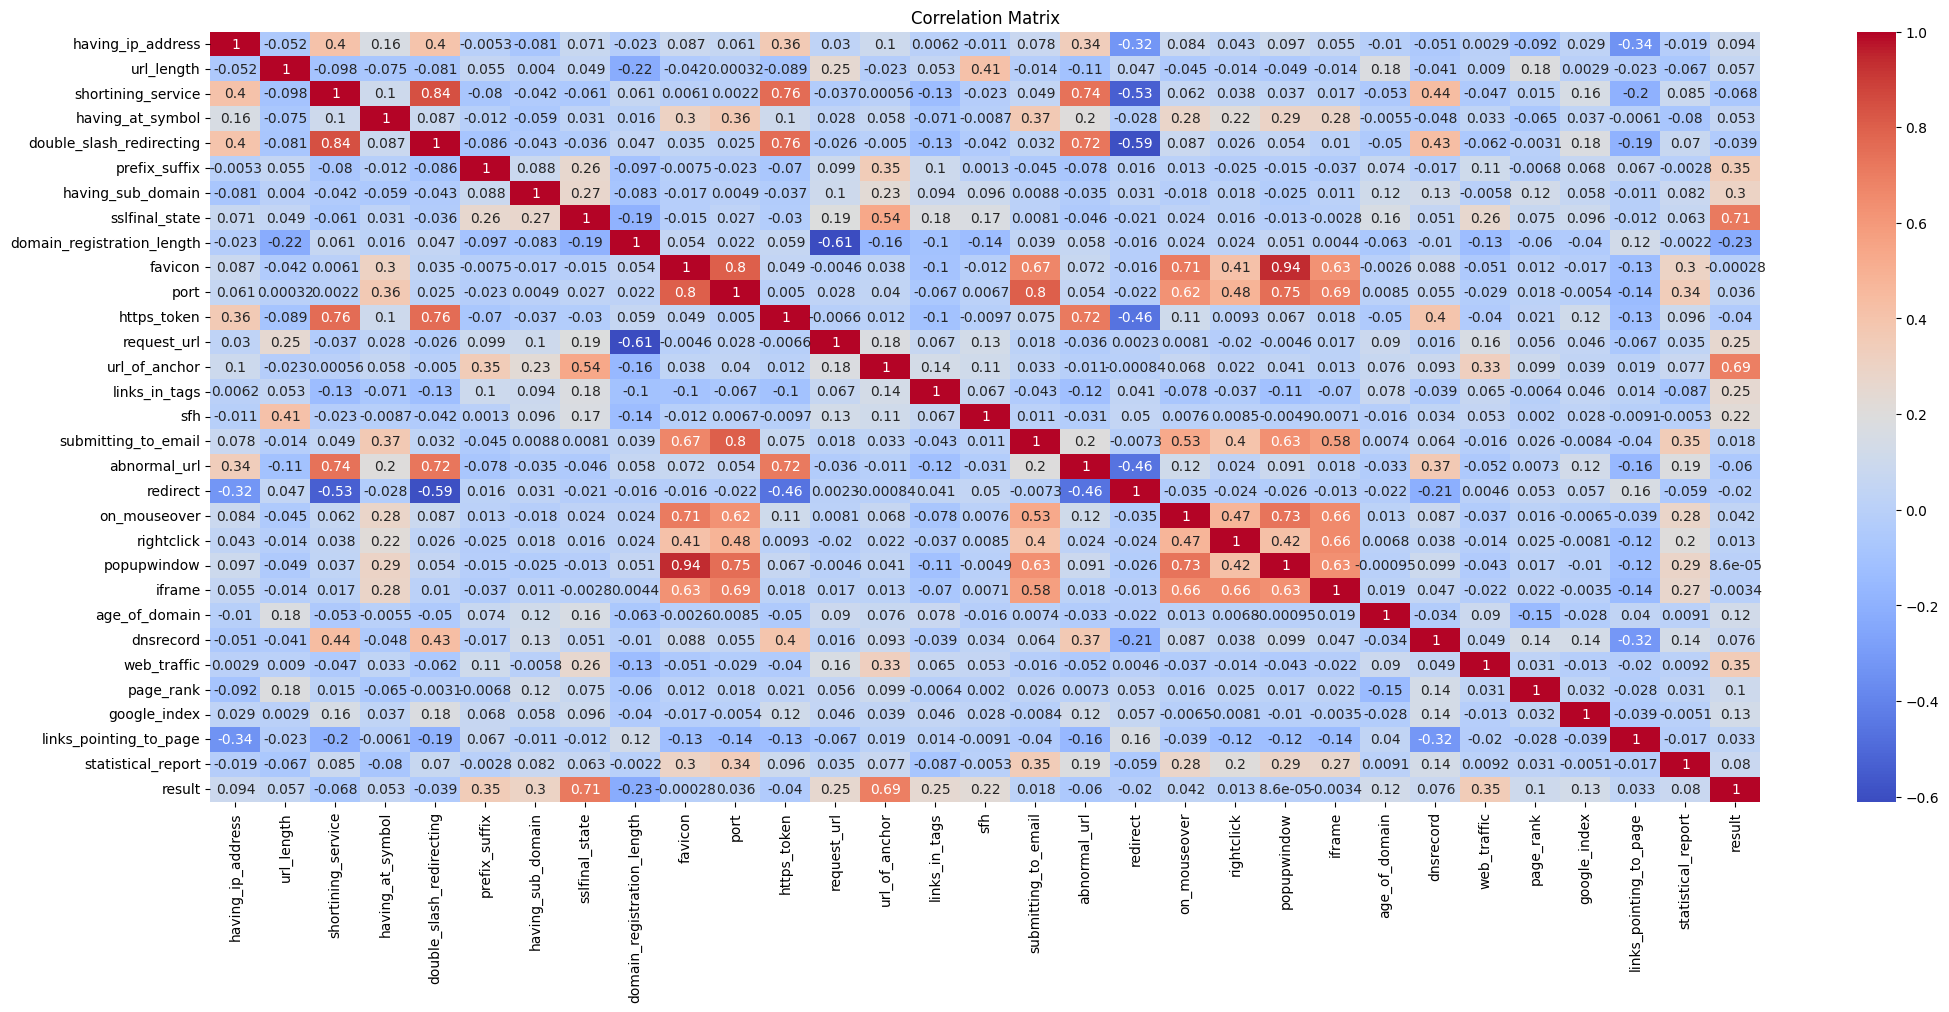

In [25]:
# concatanating the features and target variable into a single dataframe
phishing_data = pd.concat([X, y], axis=1)

corr_matrix = phishing_data.corr()

# Visualizing the correlation matrix
plt.figure(figsize=(25,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Identifying highly correlated features

In [27]:
# threshold for considering features as highly correlated
threshold = 0.8

# Find pairs of features with correlation above the threshold
corr_pairs = corr_matrix.abs().unstack().sort_values(kind="quicksort", ascending=False)
high_corr = corr_pairs[(corr_pairs < 1) & (corr_pairs >= threshold)]

print('Highly correlated feature pairs:')
print(high_corr)

Highly correlated feature pairs:
favicon                   popupwindow                 0.939633
popupwindow               favicon                     0.939633
shortining_service        double_slash_redirecting    0.842796
double_slash_redirecting  shortining_service          0.842796
favicon                   port                        0.803834
port                      favicon                     0.803834
dtype: float64


Since favicon is highly correlated with both popupwindow and port, removing favicon would address multicollinearity with two features simultaneously. But I'll not remove anything here and will go for initial training. Post training if I feel popupwindown is highly impoantant it will give me a clarity on removing favicon. The same analysis goes with shorrtning_service and double_slash_redirecting

# Model training

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [29]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:,1]

In [30]:
# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

          -1       0.98      0.96      0.97       980
           1       0.97      0.99      0.98      1231

    accuracy                           0.97      2211
   macro avg       0.98      0.97      0.97      2211
weighted avg       0.97      0.97      0.97      2211



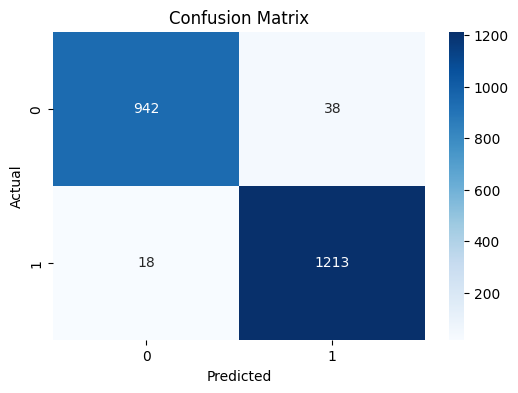

In [31]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

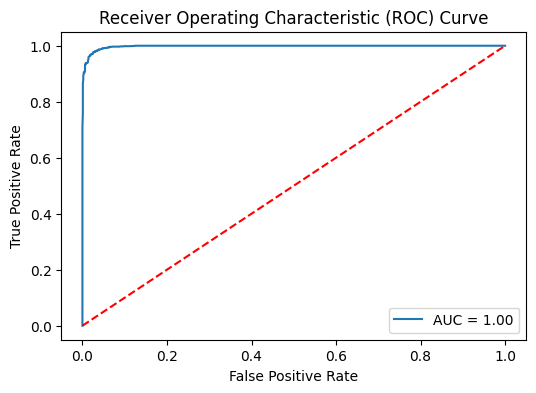

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'r--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Now that we have the model, I'm going to select top 3 features which are important for furthur analysis

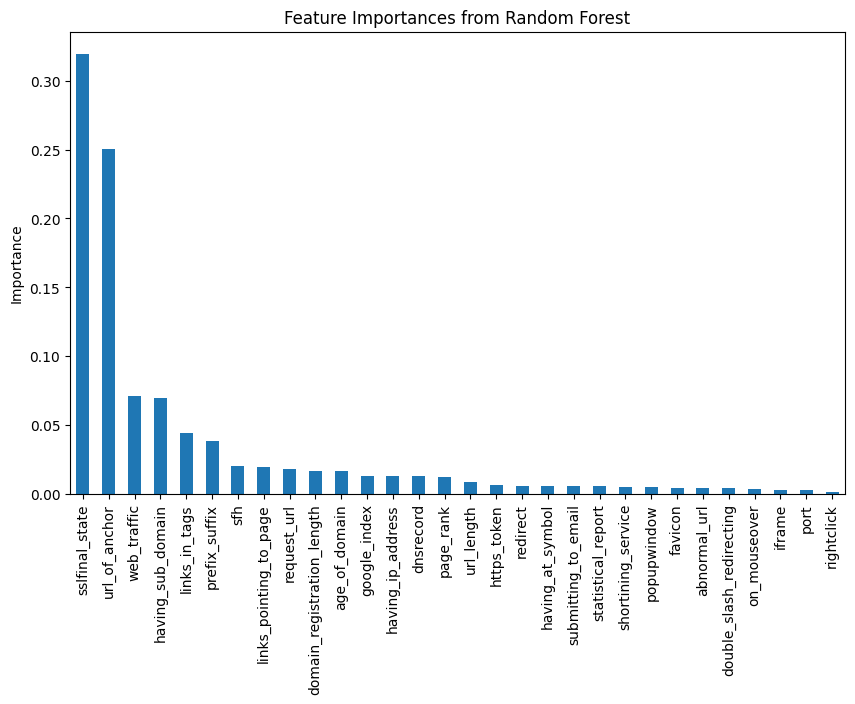

In [33]:
# Getting the feature importances
importances = rf_model.feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Visualizing feature importances
plt.figure(figsize=(10,6))
feat_imp.plot(kind='bar')
plt.title('Feature Importances from Random Forest')
plt.ylabel('Importance')
plt.show()

In [50]:
#top 3 important features
top3_features = feat_imp.index[:3]
print('Top 3 important features:')
print(top3_features)

Top 3 important features:
Index(['sslfinal_state', 'url_of_anchor', 'web_traffic'], dtype='object')


# Partial Dependence Plots (PDP)

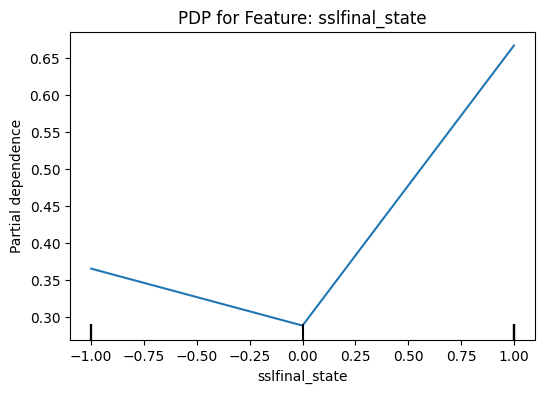

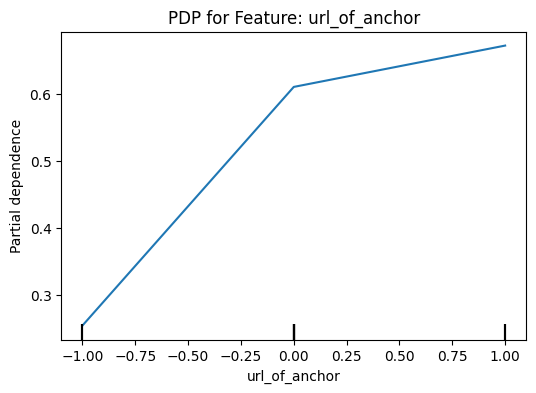

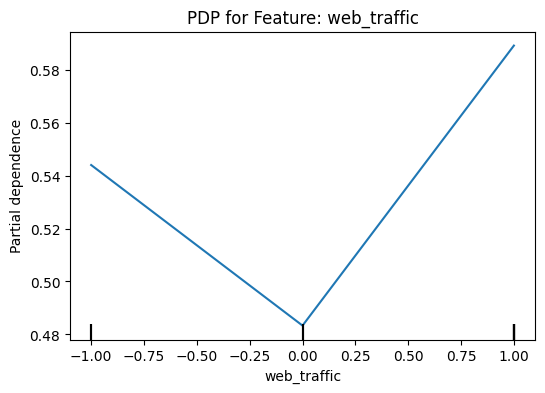

In [39]:
for feature in top3_features:
    fig, ax = plt.subplots(figsize=(6, 4))
    display = PartialDependenceDisplay.from_estimator(
        rf_model, X_test, [feature], kind='average', ax=ax)
    plt.title(f'PDP for Feature: {feature}')
    plt.show()

The Partial Dependence Plots (PDPs) for the features `sslfinal_state`, `url_of_anchor`, and `web_traffic` from the random forest model trained on the phishing UCI dataset are pretty insightful! Here’s how I interpreted each one:

### 1. **sslfinal_state**
- **Interpretation**: The plot has a non-linear shape, starting moderately high, then dipping before shooting up steeply.
- **Pattern**: It's clearly non-linear. At first, as the `sslfinal_state` decreases (becomes more negative), the prediction lowers slightly. Then, there's a sharp drop at zero before dramatically increasing as `sslfinal_state` becomes positive.
- **Slope & Limits**: The curve starts with a slight downward slope, dips at zero, and then slopes sharply upwards. No plateaus here! So, as the `sslfinal_state` gets higher, the prediction increases rapidly, suggesting that the higher the SSL state, the more likely the site is phishing.
- **Does it make sense?**: This seems pretty intuitive since websites with suspicious or incomplete SSL states might be seen as less trustworthy by the model. Once the SSL state stabilizes or increases, it could signal the model to flag the site as a phishing attempt.

### 2. **url_of_anchor**
- **Interpretation**: This plot shows a linear relationship. It's super easy to interpret because it just keeps going up!
- **Pattern**: The curve is totally linear. As the value of `url_of_anchor` increases, the partial dependence increases, meaning higher values of this feature lead to higher predictions of phishing.
- **Slope & Limits**: The upward slope is constant and doesn’t plateau, so the more aligned or structured the anchor URL is, the more likely the site is phishing, according to the model.
- **Does it make sense?**: Absolutely! Phishing sites often have certain types of URLs that trick users, so a model associating specific anchor URLs with phishing makes perfect sense to me.

### 3. **web_traffic**
- **Interpretation**: This one’s interesting because it shows a “V” shaped non-linear relationship.
- **Pattern**: The plot starts moderately high, then dips to a low point at zero and finally slopes back up. So, at first, as `web_traffic` decreases, the model predicts phishing less, but after zero, increasing traffic results in higher phishing predictions.
- **Slope & Limits**: The curve slopes downward, hits the bottom around zero, and then goes upward again. No real plateau here either—changing the traffic continues to affect predictions.
- **Does it make sense?**: At first glance, it might seem odd that low traffic doesn’t scream “phishing,” but actually, it’s intuitive. Some phishing sites might just be starting out (low traffic), while others attract lots of traffic quickly, trying to phish a large audience before they’re taken down. That "V" shape aligns with that idea!

Overall, these PDPs help us understand how each feature contributes to the phishing prediction. `sslfinal_state` and `web_traffic` show more complex, non-linear relationships, while `url_of_anchor` is a straightforward linear one. These plots confirm what we might expect—SSL state and URL structures matter a lot for phishing detection, and the amount of web traffic has an interesting non-linear effect!

# ICE Plots

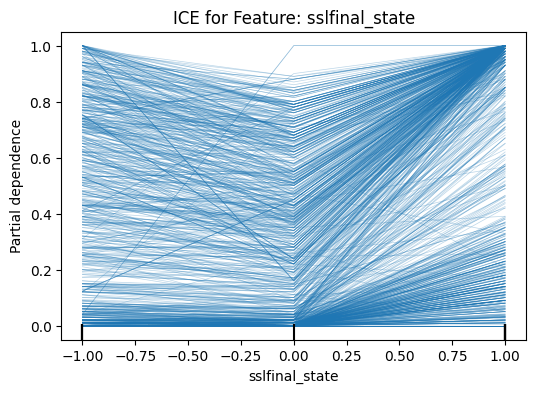

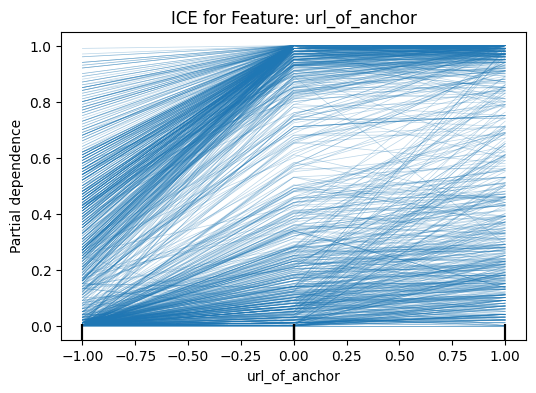

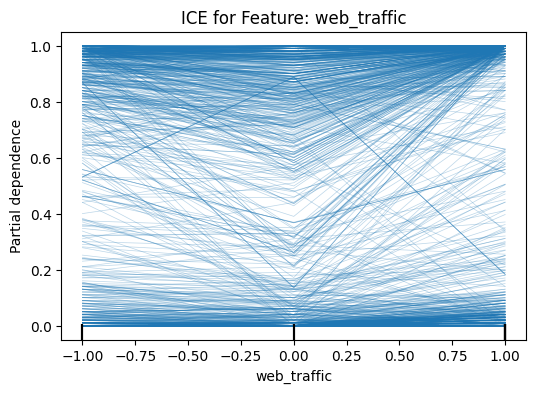

In [40]:
for feature in top3_features:
    fig, ax = plt.subplots(figsize=(6, 4))
    display = PartialDependenceDisplay.from_estimator(
        rf_model, X_test, [feature], kind='individual', ax=ax)
    plt.title(f'ICE for Feature: {feature}')
    plt.show()

The ICE plots for the features `sslfinal_state`, `url_of_anchor`, and `web_traffic` show the behavior of the model's predictions for individual data points as these features change.

### 1. **sslfinal_state**
- **Interpretation**: The ICE plot shows how individual predictions react as the `sslfinal_state` changes. Each line represents a single instance, and as you can see, the majority of the lines follow a sharp “V” shape.
- **Pattern**: It’s clearly non-linear! As `sslfinal_state` decreases (becomes negative), the prediction values for many instances drop, but then there’s a sharp turn upwards after zero. There’s quite a lot of variation here too (look at all those wiggly lines!).
- **Slope & Limits**: You can see that the slope on the right side (positive values) is quite steep, meaning that increasing `sslfinal_state` beyond zero pushes predictions higher rapidly. This suggests that most instances, when encountering high `sslfinal_state`, are predicted to be phishing.
- **Does it make sense?**: Absolutely! Websites with secure or stable SSL states (positive values) are often flagged as phishing attempts by the model. The non-linear behavior of the lines is intuitive since SSL states vary significantly between legitimate and phishing sites.

### 2. **url_of_anchor**
- **Interpretation**: This ICE plot shows a much cleaner, more linear trend compared to `sslfinal_state`. Most of the individual lines are gradually increasing, with only a few instances showing small variations.
- **Pattern**: The pattern here is mostly linear. When `url_of_anchor` increases, the partial dependence increases for nearly all instances.
- **Slope & Limits**: The slope is steady and positive—almost all the lines go up in a similar way. There’s no real plateau, meaning that higher `url_of_anchor` values consistently push the predictions higher, suggesting phishing behavior.
- **Does it make sense?**: Totally! URLs with specific anchor patterns are often manipulated in phishing attempts. So, it’s expected that as the value increases, most instances would be predicted as phishing. The consistency of the lines supports this interpretation—there’s little room for confusion!

### 3. **web_traffic**
- **Interpretation**: This ICE plot is another non-linear one! The lines mostly dip down as `web_traffic` approaches zero and then rise again as `web_traffic` increases. Some lines show more variation than others, but the "V" shape is quite prominent.
- **Pattern**: A non-linear “V” shape, similar to the `sslfinal_state` plot. For many instances, when `web_traffic` is low or zero, the predictions are lower. But as `web_traffic` increases past zero, the predictions rise again.
- **Slope & Limits**: The dip around zero is evident, but after that, the slope goes up. This means that when web traffic is high, the model sees a greater likelihood of phishing. There’s no clear plateau, so more traffic keeps pushing predictions higher for most instances.
- **Does it make sense?**: For sure! Phishing websites often fluctuate in traffic, either starting out with low traffic or trying to attract a large number of visitors quickly. The model seems to pick up on this, hence the rise in predictions with higher traffic values.

The ICE plots give us a more granular look at how individual data points react to changes in these features. For `sslfinal_state` and `web_traffic`, we see non-linear behaviors with significant variation between instances, while `url_of_anchor` shows a more uniform, linear effect across data points. These results align with what we'd expect in phishing detection: SSL states and web traffic vary more unpredictably, while URL patterns are more consistently flagged as phishing!

In [46]:
#print feature index
print('Feature Index:')
print(X.columns)

Feature Index:
Index(['having_ip_address', 'url_length', 'shortining_service',
       'having_at_symbol', 'double_slash_redirecting', 'prefix_suffix',
       'having_sub_domain', 'sslfinal_state', 'domain_registration_length',
       'favicon', 'port', 'https_token', 'request_url', 'url_of_anchor',
       'links_in_tags', 'sfh', 'submitting_to_email', 'abnormal_url',
       'redirect', 'on_mouseover', 'rightclick', 'popupwindow', 'iframe',
       'age_of_domain', 'dnsrecord', 'web_traffic', 'page_rank',
       'google_index', 'links_pointing_to_page', 'statistical_report'],
      dtype='object')


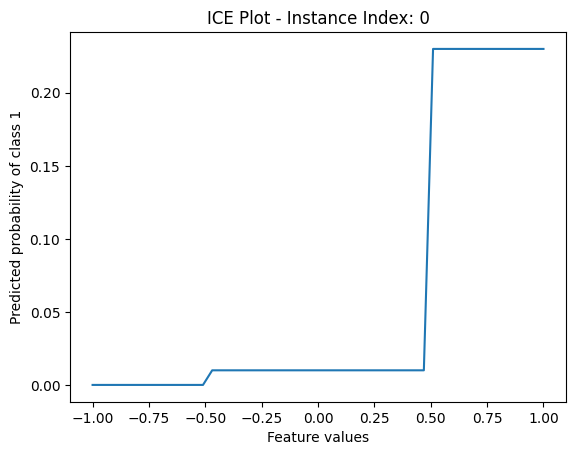

In [47]:
# Choose the instance and feature for which you want to plot the ICE plot
instance_index = 0  # Choose the index of the instance you want to visualize
feature_index = 7 #index for sslfinal_state

# Create feature grid
feature_values = np.linspace(np.min(X.iloc[:, feature_index]), np.max(X.iloc[:, feature_index]), num=50)

# Initialize array to store average predictions
average_predictions = np.zeros_like(feature_values)

# Extract the instance of interest
instance = X.iloc[[instance_index]]

# Duplicate the instance to modify feature values
instance_modified = instance.copy()

# Loop over feature values
for i, value in enumerate(feature_values):
    # Set the chosen feature to the current value for the instance:
    instance_modified.iloc[:, feature_index] = value

    # Predict using the modified instance:
    prediction = rf_model.predict_proba(instance_modified)[:, 1]

    # Store the prediction for the current feature value:
    average_predictions[i] = prediction.item()

# Plot the ICE plot
plt.plot(feature_values, average_predictions)
plt.xlabel(f'Feature values')
plt.ylabel('Predicted probability of class 1')
plt.title(f'ICE Plot - Instance Index: {instance_index}')
plt.show()

For instance index 0 and the feature `sslfinal_state`, the ICE plot shows a sharp increase in predicted probability of class 1 (likely phishing) around feature values greater than 0. Before that, the probability remains close to 0, indicating that lower SSL states do not contribute much to the phishing prediction. Once `sslfinal_state` crosses 0.5, the predicted probability jumps significantly and plateaus around 0.25, indicating a strong contribution to phishing prediction for higher SSL states.

# ALE Plots

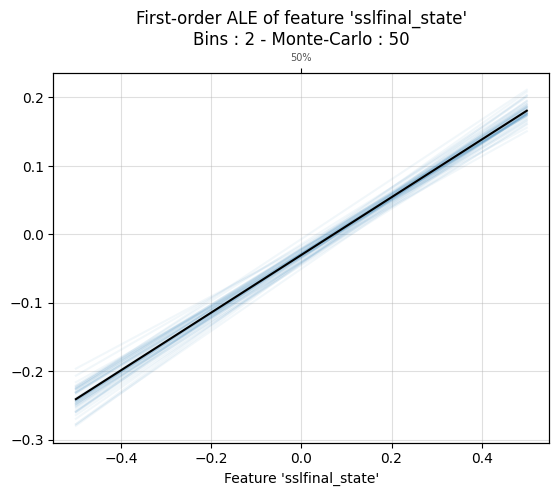

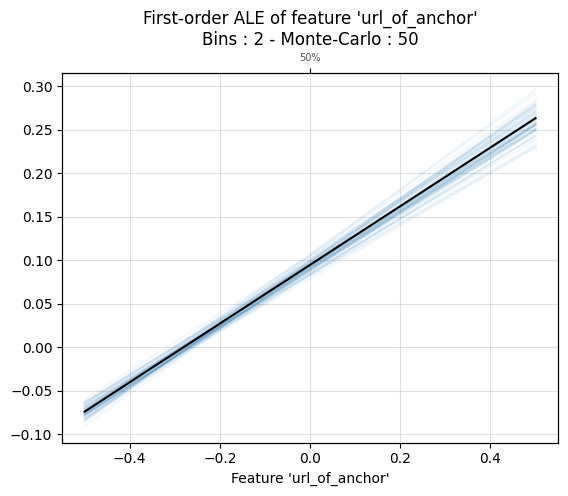

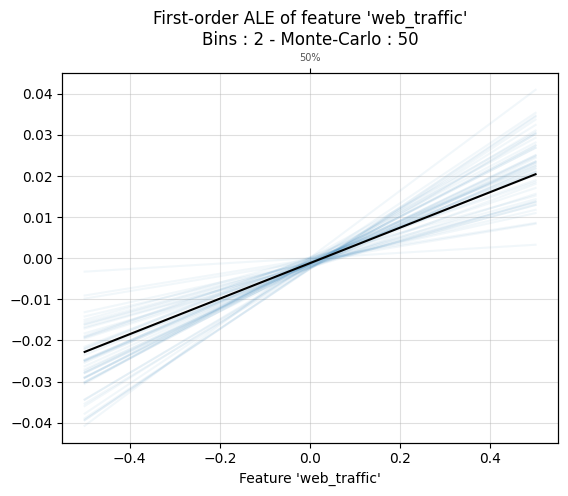

In [60]:
for feature in top3_features:
    ale_plot(rf_model, X_train, feature, bins=20, monte_carlo=True)

### 1. **sslfinal_state** ALE Plot
- **X-axis (Feature Values)**: This represents the different values of `sslfinal_state` in the dataset, ranging from around -0.4 to 0.5.
- **Y-axis (Effect on Predictions)**: The Y-axis shows the average effect this feature has on the model’s predictions.
- **Interpretation**:
  - The curve is **upward sloping** across the feature values, indicating that as the value of `sslfinal_state` increases, the model's predictions (phishing likelihood) also increase.
  - The curve isn’t steep initially, but it rises sharply after 0, showing that higher values of `sslfinal_state` significantly increase the prediction probability.
  - **Does it make sense?**: Yes, as `sslfinal_state` moves towards higher values, which likely indicate more secure or confirmed SSL statuses, the prediction that a site is phishing increases, matching intuition.

### 2. **url_of_anchor** ALE Plot
- **X-axis (Feature Values)**: The values of the `url_of_anchor` feature range from -0.4 to 0.5.
- **Y-axis (Effect on Predictions)**: Shows the average effect on the predictions as this feature value changes.
- **Interpretation**:
  - The curve is **steadily upward sloping**, indicating a **linear relationship**. As the value of `url_of_anchor` increases, the predicted probability of phishing also increases.
  - The curve is fairly steep, meaning this feature has a **significant impact** on the model’s predictions. Higher values of `url_of_anchor` contribute heavily to classifying a website as phishing.
  - **Does it make sense?**: Definitely! As certain types of URLs in the anchor are associated with phishing, it makes sense that higher values lead to increased phishing predictions.

### 3. **web_traffic** ALE Plot
- **X-axis (Feature Values)**: This ranges from around -0.4 to 0.5, representing different levels of web traffic.
- **Y-axis (Effect on Predictions)**: Reflects the average effect this feature has on predictions.
- **Interpretation**:
  - The curve is **slightly upward sloping**, showing that as web traffic increases, the phishing prediction slightly increases.
  - However, the curve is much flatter compared to the other two features, meaning `web_traffic` has a **smaller impact** on predictions than `sslfinal_state` or `url_of_anchor`.
  - **Does it make sense?**: Yes, phishing sites might have varying levels of traffic, but web traffic alone isn’t as strong a signal as SSL states or URL anchors in identifying phishing sites. Hence, the effect is more modest.

- **sslfinal_state** and **url_of_anchor** have **steep upward curves**, meaning they both significantly increase the phishing predictions as their values rise.
- **web_traffic** has a **less pronounced effect**, contributing to the prediction but not as strongly as the other two features.
  
These insights align well with how phishing sites typically behave—certain SSL states and URL structures are stronger indicators than web traffic alone!

### Differences between PDP and ALE Plots:
- The **PDPs** for `sslfinal_state`, `url_of_anchor`, and `web_traffic` showed fairly linear or non-linear trends, but they might not have fully captured the interactions between features.
- The **ALE plots**, on the other hand, showed more refined insights. For example, the linear trend in the `sslfinal_state` ALE plot indicated a clearer upward effect, and the ALE plots also accounted for correlations better by handling local changes in the data.

### Correlation Insights and Impact on Results:
Looking at the **correlation matrix**:
- **sslfinal_state** shows a high correlation with `having_sub_domain` (0.71) and moderate correlation with `url_of_anchor` (0.17). This suggests that `sslfinal_state` is not entirely independent and interacts with other features, especially `having_sub_domain`.
  - In the **PDP**, we saw a sharp upward trend in predictions for `sslfinal_state` as it increased, but the ALE plot handled this correlation better by showing a more localized, linear upward trend. Since ALE considers feature interactions, it provides a clearer picture of `sslfinal_state`'s true influence.
  
- **url_of_anchor** has a strong correlation with `abnormal_url` (0.76), and this could skew the PDP, especially in cases where these features interact. The ALE plot likely provides a more accurate portrayal of how `url_of_anchor` influences predictions, given that it corrects for the interaction with `abnormal_url`.

- **web_traffic** has a moderate correlation with `statistical_report` (0.35), which could affect how its PDP is displayed. The ALE plot for `web_traffic` showed a very slight upward trend, which is likely a more accurate representation of its influence, as the correlations in the matrix suggest that `web_traffic` on its own isn’t a huge predictor but interacts with other features.

- The strong correlation between features like `sslfinal_state` and `having_sub_domain` indicates that their effects on phishing prediction might not be entirely independent. While PDPs show overall trends, they don't reveal these subtle dependencies.
- The **correlation between `url_of_anchor` and `abnormal_url`** suggests that phishing sites often exhibit both characteristics together. Hence, the PDP may overstate the impact of `url_of_anchor` alone, while ALE shows a more grounded effect by controlling for these interactions.
  
While PDPs give a broad idea of feature importance, **ALE plots offer a more accurate representation** when features are correlated, as they take feature interactions into account. The correlation matrix confirms that many of the features in this dataset interact, which is why the **ALE plots** are more reliable for understanding how each feature truly impacts phishing predictions.

# Reference:

Code reference: https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/global_explanations.ipynb

PDP and ICE plot: https://scikit-learn.org/stable/modules/generated/sklearn.inspection.PartialDependenceDisplay.html

ALE plot: https://github.com/blent-ai/ALEPython

Dataset copyright:
R. Mohammad and L. McCluskey. "Phishing Websites," UCI Machine Learning Repository, 2012. [Online]. Available: https://doi.org/10.24432/C51W2X.
